# Model training and prediction - `composite`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [8]:
X_train = pd.read_csv("./data/processed/composite/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/composite/y_train.csv", index_col = 0).composite
X_test = pd.read_csv("./data/processed/composite/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/composite/y_test.csv", index_col = 0).composite
tc_train = pd.read_csv("./data/processed/composite/tc_train.csv", index_col = 0).tc
tc_test = pd.read_csv("./data/processed/composite/tc_test.csv", index_col = 0).tc

In [9]:
y_train.value_counts() / len(y_train.index) * 100

0    98.167497
1     1.832503
Name: composite, dtype: float64

In [10]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [11]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [12]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [14]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [15]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [16]:
# lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    # lgbm,
    lr,
    rf
]

In [17]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [18]:
from src.models.classifiers import StackedGeneralizationClassifier

In [19]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
y_test_prob_con, y_test_prob_cut = sgclf.predict(X_test)

In [21]:
from sklearn.metrics import roc_auc_score

In [22]:
auc_test_con = roc_auc_score(y_score = y_test_prob_con, y_true = y_test)
("Hold-out AUC of ROC, continous model: " + 
str(auc_test_con))

'Hold-out AUC of ROC, continous model: 0.647968152207631'

In [23]:
auc_test_cut = roc_auc_score(y_score = y_test_prob_cut, y_true = y_test)
("Hold-out AUC of ROC, cut model: " + 
str(auc_test_cut))

'Hold-out AUC of ROC, cut model: 0.5'

In [24]:
from src.visualization.visualize import plot_roc, plot_precision_recall

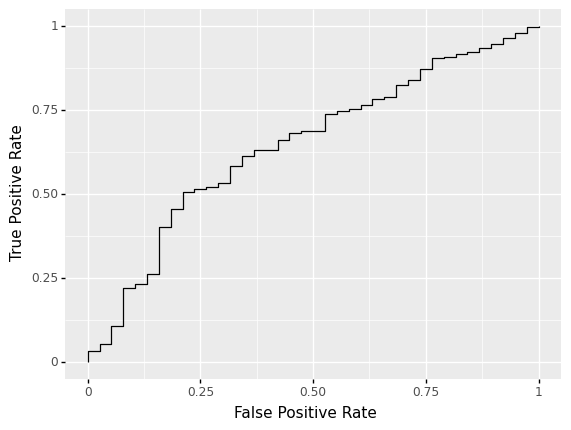

<ggplot: (369654493)>

In [27]:
plot_roc(y_test, y_test_prob_con)

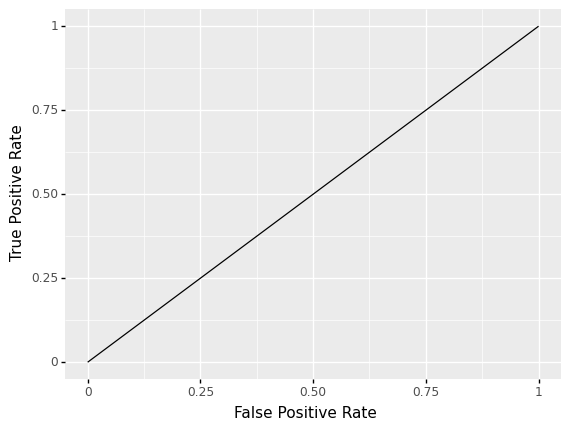

<ggplot: (357157090)>

In [30]:
plot_roc(y_test, y_test_prob_cut)

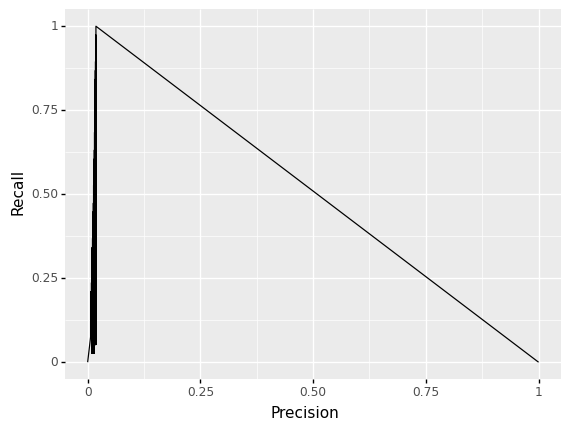

<ggplot: (357114355)>

In [31]:
plot_precision_recall(y_test, y_test_prob_con)

Plot roc curves for each classifier

In [32]:
from src.visualization.visualize import plot_roc_base_clfs

In [33]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [34]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [35]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [36]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [37]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_prob_con))

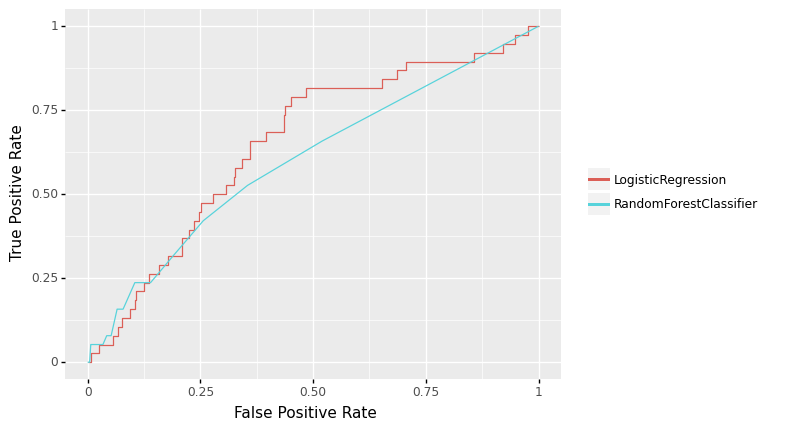

<ggplot: (369568784)>

In [38]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [39]:
from src.models.metrics import bootstrap, compute_performance

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [40]:
stats = bootstrap(
    X=X_train,
    y=y_train, 
    tc=tc_train,
    keys=keys + [sgclf.__class__.__name__],
    base_clfs=base_clfs,
    meta_clf=LogisticRegression(),
    all_hyper_parameters=all_hyper_parameters
)

  0%|                                                                          | 0/5 [00:00<?, ?it/s]During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-de

  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI           0.031273670
NRI+          0.025210084
NRI-          0.006063586
Pr(Up|Case)   0.134453782
Pr(Down|Case) 0.109243697
Pr(Down|Ctrl) 0.114880367
Pr(Up|Ctrl)   0.108816781
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.15360078
NRI+           0.21551724
NRI-          -0.06191646
Pr(Up|Case)    0.28448276
Pr(Down|Case)  0.06896552
Pr(Down|Ctrl)  0.10630631
Pr(Up|Ctrl)    0.16822277


/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

  0%|          | 0/4 [00:00<?, ?it/s]
                Estimate
NRI           0.10584117
NRI+          0.07964602
NRI-          0.02619515
Pr(Up|Case)   0.15044248
Pr(Down|Case) 0.07079646
Pr(Down|Ctrl) 0.11673215
Pr(Up|Ctrl)   0.09053700
  0%|          | 0/4 [00:00<?, ?it/s]
                  Estimate
NRI           -0.003357269
NRI+          -0.049586777
NRI-           0.046229508
Pr(Up|Case)    0.099173554
Pr(Down|Case)  0.148760331
Pr(Down|Ctrl)  0.119016393
Pr(Up|Ctrl)    0.072786885
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.10456193
NRI+           0.16981132
NRI-          -0.06524939
Pr(Up|Case)    0.27358491
Pr(Down|Case)  0.10377358
Pr(Down|Ctrl)  0.10923957
Pr(Up|Ctrl)    0.17448896


/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



In [41]:
# Set bootstrap estimates as data frame
stats_df = pd.concat([pd.DataFrame.from_dict(d, orient="index").stack().to_frame() for d in stats], axis = 1)
stats_df.values.sort()
# Set list for simplifying compiling point estimates
y_test_prob_cuts = [None] * len(keys) + [y_test_prob_cut]
# Set point estimates as data frame
point_estimates = pd.DataFrame.from_dict({
    k: compute_performance(
        y_prob=prob, 
        y_pred=pred, 
        y_true=y_test, 
        y_pred_cut=cut, 
        tc=tc_test
    )
    for prob, pred, cut, k in zip(
        y_test_prob_clfs.T, 
        y_test_pred_clfs.T,
        y_test_prob_cuts,
        keys + [sgclf.__class__.__name__]
    )
}, orient = "index").stack().to_frame()
# Compute quantiles for each metric
d1 = (stats_df - point_estimates).apply(np.quantile, q = 0.1, axis = 1)
d2 = (stats_df - point_estimates).apply(np.quantile, q = 0.9, axis = 1)
# Compute upper bounds and lower bounds
ub = round(point_estimates - d1.to_frame(), 2)
lb = round(point_estimates - d2.to_frame(), 2)
# Compile performamance
perf_df = pd.concat([round(point_estimates, 2), lb, ub, ], axis = 1)

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                Estimate
NRI           -0.1779806
NRI+          -0.2894737
NRI-           0.1114931
Pr(Up|Case)    0.0000000
Pr(Down|Case)  0.2894737
Pr(Down|Ctrl)  0.1114931
Pr(Up|Ctrl)    0.0000000


In [42]:
lb_str = lb.iloc[:, 0].astype(str) 
ub_str = ub.iloc[:, 0].astype(str)
pe_str = round(point_estimates, 2).iloc[:, 0].astype(str)
ci = pe_str + " (" + lb_str + " to " + ub_str +  ")"

In [43]:
perf_df = pd.concat([perf_df, ci.to_frame()], axis = 1)
perf_df.columns = ["point_estimate", "lb", "ub", "ci"]

In [44]:
perf_df

point_estimate    lb    ub  \
LogisticRegression              roc_auc              0.65  0.67  0.70   
                                prec                 0.49  0.49  0.49   
                                rec                  0.50  0.50  0.50   
RandomForestClassifier          roc_auc              0.60  0.60  0.63   
                                prec                 0.49  0.49  0.49   
                                rec                  0.50  0.50  0.50   
StackedGeneralizationClassifier roc_auc              0.65  0.68  0.72   
                                prec                 0.49  0.49  0.49   
                                rec                  0.50  0.50  0.50   
                                nri                 -0.18 -0.49 -0.37   
                                nri_plus            -0.29 -0.78 -0.56   
                                nri_minus            0.11  0.18  0.29   

                                                               ci  
LogisticRegression              roc_auc        0.65 (0.67 to 0.7)  
                                prec          0.49 (0.49 to 0.49)  
                                rec              0.5 (0.5 to 0.5)  
RandomForestClassifier          roc_auc         0.6 (0.6 to 0.63)  
                                prec          0.49 (0.49 to 0.49)  
                                rec              0.5 (0.5 to 0.5)  
StackedGeneralizationClassifier roc_auc       0.65 (0.68 to 0.72)  
                                prec          0.49 (0.49 to 0.49)  
                                rec              0.5 (0.5 to 0.5)  
                                nri        -0.18 (-0.49 to -0.37)  
                                nri_plus   -0.29 (-0.78 to -0.56)  
                                nri_minus     0.11 (0.18 to 0.29)

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In p.newc - p.stdc :
R[write to console]: 
 
R[write to console]:  longer object length is not a multiple of shorter object length

R[write to console]: 2: 
R[write to console]: In p.newc - p.stdc :
R[write to console]: 
 
R[write to console]:  longer object length is not a multiple of shorter object length

R[write to console]: 3: 
R[write to console]: In p.newc - p.stdc :
R[write to console]: 
 
R[write to console]:  longer object length is not a multiple of shorter object length

R[write to console]: 4: 
R[write to console]: In p.newc - p.stdc :
R[write to console]: 
 
R[write to console]:  longer object length is not a multiple of shorter object length

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In p.newc - p.stdc :
R[write to console]: 
 
R[write to console]:  longer object length is not a multiple of shorter object length

R[write to console]: 2: 
R[wri